In [63]:
from copy import deepcopy

import torch
import numpy as np
import matplotlib.pyplot as plt

from arithmetic_lm.model import UniversalTransformer, generate
from arithmetic_lm.tokenizer import CharTokenizer

In [2]:
ckpt_path = "../checkpoints/addition-1-9-digit-pad/ut_1steps_384embd_2head/step=15500-train_loss=0.0108-val_loss=4.6606.ckpt"

In [3]:
tokenizer = CharTokenizer()

In [69]:
# load model
ckpt = torch.load(ckpt_path, map_location="mps")
model = UniversalTransformer(
    **ckpt["hyper_parameters"]["model_hparams"], vocab_size=tokenizer.vocab_size
)
# state dict has a prefix "model." in the key names
model.load_state_dict({k[6:]: v for k, v in ckpt["state_dict"].items()})
model.eval()

UniversalTransformer(
  (embedding): Embedding(100, 384, padding_idx=99)
  (coord_encoder): CoordinateEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
    )
    (linear1): Linear(in_features=384, out_features=1536, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1536, out_features=384, bias=True)
    (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): 

In [5]:
def eval_answer_addition(
    model,
    tokenizer,
    a: int,
    b: int,
    pad_zeros: int = 10,
    max_len: int = 11,
    verbose: bool = False,
) -> tuple[int, bool]:
    # compute real answer
    real_answer = a + b

    # prepare prompt
    prompt = f"\n${str(a).zfill(pad_zeros)}+{str(b).zfill(pad_zeros)}"
    if verbose:
        print(f"prompt: {prompt}")
    prompt = tokenizer.encode(prompt)
    prompt = torch.tensor(prompt)

    # generate
    out_ids = generate(
        model=model,
        idx=torch.tensor(tokenizer.encode("=")),
        max_new_tokens=max_len,
        encoder_source=prompt,
        stop_token=tokenizer.encode("$")[0],
    )
    out = tokenizer.decode(out_ids[0].tolist())
    if verbose:
        print(f"output: {out}")

    # extract answer
    pred_answer = int(out.replace("$", ""))
    return out, pred_answer == real_answer

In [6]:
a = 199999
b = 4562
out, correct = eval_answer_addition(
    model, tokenizer, a, b, pad_zeros=10, max_len=12, verbose=True
)
print(f"true answer: {a+b}")
print(f"correct: {correct}")

prompt: 
$0000199999+0000004562
output: 00000204561$
true answer: 204561
correct: True


## Evaluate different number of digits in operands

Model is trained on NxN (0-padded) addition, where both operands have the same number of digits. We evaluate the model on addition of two numbers with different number of digits (still padded to same length). 

In [7]:
# matrix of accuracy
max_digits = 10
n_samples_per_cell = 100
pad_zeros = 10

accuracy_matrix = np.zeros((max_digits, max_digits))
mistakes = []

for n_a in range(1, max_digits + 1):
    for n_b in range(1, max_digits + 1):
        correct = 0
        for _ in range(n_samples_per_cell):
            # generate random numbers
            a = np.random.randint(10 ** (n_a - 1), 10**n_a)
            b = np.random.randint(10 ** (n_b - 1), 10**n_b)
            _, is_correct = eval_answer_addition(
                model, tokenizer, a, b, pad_zeros=pad_zeros, max_len=12, verbose=False
            )
            # save mistakes
            if not is_correct:
                mistakes.append((a, b))
            correct += is_correct
        accuracy_matrix[n_a - 1, n_b - 1] = correct / n_samples_per_cell

print(accuracy_matrix)

[[1.   1.   1.   1.   1.   1.   1.   1.   0.98 0.  ]
 [1.   1.   1.   0.98 0.99 1.   1.   0.99 0.99 0.  ]
 [1.   1.   1.   1.   1.   0.99 0.98 0.97 1.   0.  ]
 [1.   1.   1.   1.   0.99 0.97 0.98 0.98 0.97 0.  ]
 [1.   1.   0.99 1.   0.99 0.97 1.   0.95 0.98 0.  ]
 [1.   1.   0.98 0.98 1.   0.98 0.97 0.97 0.97 0.  ]
 [0.99 0.99 1.   0.99 0.99 0.92 0.99 0.96 0.94 0.  ]
 [1.   1.   0.99 0.98 0.95 0.96 0.88 0.6  0.98 0.01]
 [0.97 0.96 0.94 0.95 0.92 0.95 0.96 0.83 0.98 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.09]]


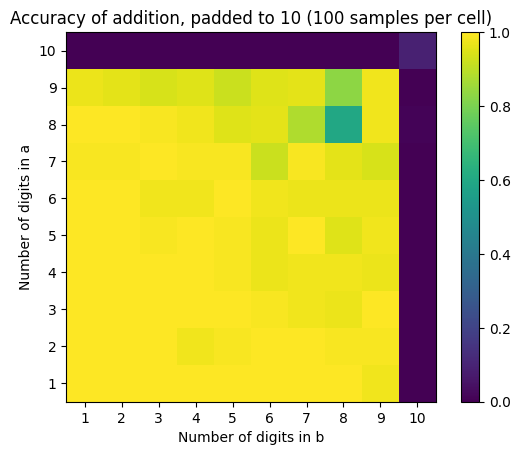

In [8]:
# plot accuracy matrix
plt.imshow(accuracy_matrix, cmap="viridis", interpolation="none")
plt.colorbar()
# set xtiks and yticks to be integers
plt.xticks(np.arange(max_digits), np.arange(1, max_digits + 1))
plt.yticks(np.arange(max_digits), np.arange(1, max_digits + 1))
plt.xlabel("Number of digits in b")
plt.ylabel("Number of digits in a")
plt.title(
    f"Accuracy of addition, padded to {pad_zeros} ({n_samples_per_cell} samples per cell)"
)
# invert y axis
plt.gca().invert_yaxis()
plt.show()

In [11]:
# print mistakes
for a, b in mistakes[-5:]:
    out, correct = eval_answer_addition(
        model, tokenizer, a, b, pad_zeros=pad_zeros, max_len=12, verbose=False
    )
    if not correct:
        n_a = len(str(a))
        n_b = len(str(b))
        out_int = int(out.replace("$", ""))
        n_true_ans = len(str(a + b))
        n_pred_ans = len(str(out_int))
        print(f"{a} + {b} = {a+b}")
        print(
            " " * (n_a + n_b + (n_true_ans - n_pred_ans))
            + f"pred: {out_int} ({out}) [{n_a}+{n_b} digit]"
        )
        print()

9666526984 + 9049891020 = 18716418004
                    pred: 88616418004 (88616418004$) [10+10 digit]

2454686047 + 8642336167 = 11097022214
                    pred: 11097022215 (11097022215$) [10+10 digit]

2634669234 + 1884757589 = 4519426823
                    pred: 1519426823 (01519426823$) [10+10 digit]

4920621115 + 9955806346 = 14876427461
                    pred: 44876427462 (44876427462$) [10+10 digit]

4540242457 + 4709173963 = 9249416420
                    pred: 1249416421 (01249416421$) [10+10 digit]



## Ablate residual stream of the encoder

In [130]:
def predict_next_ablating_res_stream(
    model: torch.nn.Module,
    prompt: torch.Tensor,
    decoder_prompt: torch.Tensor,
    ablate_positions: list[int],
) -> str:
    """
    Predict next token while ablating positions in the residual stream
    at the end of encoder. ablate_positions is a list of integers
    of positions in the sequence to set to zero.
    """

    hooked_model = deepcopy(model)
    hooked_model.eval()

    # hook
    def mean_ablate_pos_in_res_stream(module, args, kwargs, output):
        # set output to mean at ablated positions
        # output shape = [bs, seq_len, d_model]
        output[:, ablate_positions, :] = output.mean(dim=1, keepdim=True)
        return output

    hooked_model.encoder_layer.register_forward_hook(
        mean_ablate_pos_in_res_stream, with_kwargs=True
    )

    logits = hooked_model(source=prompt, target=decoder_prompt)[0, -1, :]
    pred_token = torch.argmax(logits).item()
    pred_token_str = tokenizer.decode([pred_token])

    # delete hooked model
    del hooked_model

    return pred_token_str

In [133]:
a = 123
b = 456
decoder_prompt_str = "=00000000"

prompt_str = f"\n${str(a).zfill(pad_zeros)}+{str(b).zfill(pad_zeros)}"
print("prompt:", repr(prompt_str))
true_ans = a + b
print("true_ans:", true_ans)

# just before first actual digit
decoder_prompt = torch.tensor([tokenizer.encode(decoder_prompt_str)])
print(f"decoder prompt:", decoder_prompt_str)

prompt = tokenizer.encode(prompt_str)
prompt = torch.tensor([prompt])

# without ablation
logits = model(source=prompt, target=decoder_prompt)[0, -1, :]
pred_token = torch.argmax(logits).item()
print("pred_token_str:", tokenizer.decode([pred_token]))

# ablating digits
for i in range(prompt.shape[1]):
    pred_token_ablated = predict_next_ablating_res_stream(
        model, prompt, decoder_prompt, [i]
    )
    # str representation of ablation, set positions to '.'
    ablated_prompt_str = prompt_str[:i] + "." + prompt_str[i + 1 :]
    print(repr(ablated_prompt_str), pred_token_ablated)


# ablating multiple digits
ablate_digits = list(range(21))
pred_token_ablated = predict_next_ablating_res_stream(
    model, prompt, decoder_prompt, ablate_digits
)
ablated_prompt_str = [
    "." if i in ablate_digits else c for i, c in enumerate(prompt_str)
]
ablated_prompt_str = "".join(ablated_prompt_str)
print(repr(ablated_prompt_str), pred_token_ablated)

prompt: '\n$0000000123+0000000456'
true_ans: 579
decoder prompt: =00000000
pred_token_str: 5
'.$0000000123+0000000456' 5
'\n.0000000123+0000000456' 5
'\n$.000000123+0000000456' 5
'\n$0.00000123+0000000456' 5
'\n$00.0000123+0000000456' 5
'\n$000.000123+0000000456' 5
'\n$0000.00123+0000000456' 5
'\n$00000.0123+0000000456' 5
'\n$000000.123+0000000456' 5
'\n$0000000.23+0000000456' 5
'\n$00000001.3+0000000456' 5
'\n$000000012.+0000000456' 5
'\n$0000000123.0000000456' 5
'\n$0000000123+.000000456' 5
'\n$0000000123+0.00000456' 5
'\n$0000000123+00.0000456' 5
'\n$0000000123+000.000456' 5
'\n$0000000123+0000.00456' 5
'\n$0000000123+00000.0456' 5
'\n$0000000123+000000.456' 5
'\n$0000000123+0000000.56' 5
'\n$0000000123+00000004.6' 5
'\n$0000000123+000000045.' 5


/Users/imran/Library/Caches/pypoetry/virtualenvs/msc-thesis-P7I560r2-py3.12/lib/python3.12/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


'.....................56' 7
